This notebook implements the viscoelastic beam-bending problem shown in Gerya's chapter 13 and in the benchmark chapter (chapter 20).


In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [37]:
# Functions related to problem setup
struct Materials
    # 1 - beam
    # 2 - beam (second color)
    # 3 - viscous fluid
    # 4 - viscous fluid (second color)
    alpha::Vector{Float64} # thermal expansivity
    rho0::Vector{Float64}  # reference density
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    mu::Vector{Float64} # elastic shear modulus
    function Materials()
         # These are the values used in Gerya's Fig 20.12  (Benchmarks chapter)
         new([0.0,0.0,0.0,0.0],[4000.0,4000.0,1.0,1.0],[0.0,0.0,0.0,0.0],[1e3,1e3,1e3,1e3],[2.0,2.0,2.0,2.0],[1e27,1e27,1e21,1e21],[1e10,1e10,1e20,1e20])
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    # T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    mu = markers.scalarFields["mu"]
    rho = markers.scalarFields["rho"]
    # alpha = markers.scalarFields["alpha"]
    # cp = markers.scalarFields["Cp"]
    # kThermal = markers.scalarFields["kThermal"]
    # Hr = markers.scalarFields["Hr"]
    exx = markers.scalarFields["exx"]
    exy = markers.scalarFields["exy"]
    sxx = markers.scalarFields["sxx"]
    sxy = markers.scalarFields["sxy"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mmat::Int64 = 0
        if mx < 8e5 && my > 2e5 && my < 8e5
            mmat = 1            
         else
            mmat = 3
        end
        cs = 1e5
        if (mod(mx,cs) > cs/2 && mod(my,cs) < cs/2) || (mod(mx,cs) < cs/2 && mod(my,cs) > cs/2)
            mmat += 1
        end
        
        # beam
        markers.integers[material,i] = mmat
        # markers.scalars[T,i] = 0.0
        # markers.scalars[kThermal,i] = materials.kThermal[mmat]
        markers.scalars[eta,i] = materials.eta[mmat]
        markers.scalars[mu,i] = materials.mu[mmat]
        markers.scalars[rho,i] = materials.rho0[mmat]
        # markers.scalars[alpha,i] = materials.alpha[mmat]  
        # markers.scalars[cp,i] = materials.Cp[mmat]  
        # markers.scalars[Hr,i] = materials.Hr[mmat]
        # initialize stress/strain
        markers.scalars[sxx,i] = 0.0
        markers.scalars[sxy,i] = 0.0
        markers.scalars[exx,i] = 0.0
        markers.scalars[exy,i] = 0.0    
    end
end


initial_conditions! (generic function with 1 method)

In [53]:
# Functions related to plotting:
function plot_material(markers::Markers)
    # Visualize the materials:
    figure()
    nmark = markers.nmark
    scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=markers.integers[markers.integerFields["material"],1:nmark],s=0.01)
    axis("equal")
    colorbar()
    show()
end

function plot_rheology(markers::Markers)
    # plot viscosity and shear modulus
    f,(ax1,ax2) = subplots(1,2)
    
    nmark = markers.nmark
    h1 = ax1.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=log10.(markers.scalars[markers.scalarFields["eta"],1:nmark]),s=0.01)
    ax1.set_aspect("equal")
    colorbar(h1,ax=ax1)
    ax1.set_title("log10(eta)")
    h2=ax2.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=log10.(markers.scalars[markers.scalarFields["mu"],1:nmark]),s=0.01)
    ax2.set_aspect("equal")
    colorbar(h2,ax=ax2)
    ax2.set_title("log10(mu)")
end

plot_rheology (generic function with 1 method)

Creating Markers...
  0.000331 seconds (33 allocations: 12.317 MiB)
Initial condition...
  0.001869 seconds
Writing visualization fle test/viz.0000.vtr
  0.000249 seconds (2 allocations: 1.346 MiB)
Min/Max velocity: -1.8693119465520273e-7 2.7054938462984073e-8
Finished Step 1 time=0.001 Myr
  0.306966 seconds (2.54 k allocations: 100.149 MiB, 0.90% gc time)


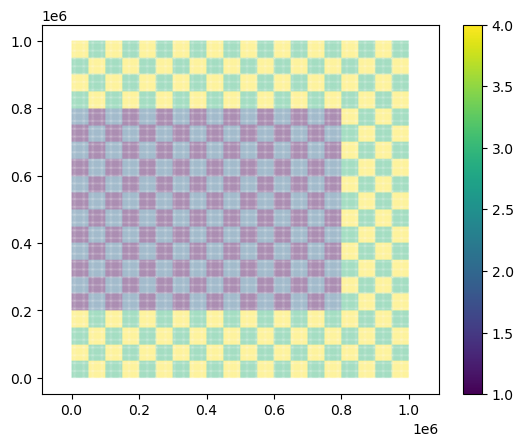

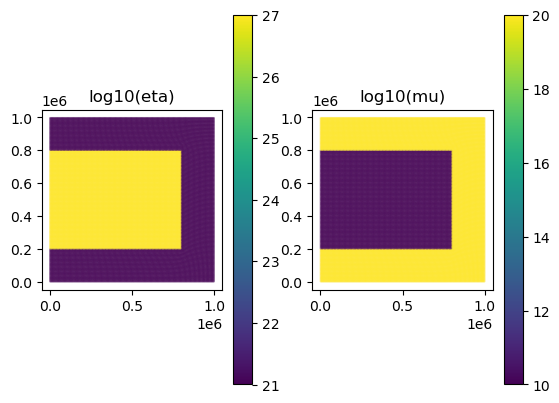

PyObject Text(0.5, 1.0, 'log10(mu)')

In [55]:
# Main function - based on I2VIS notebook
function run(nstep::Int64)
    nx = 51
    ny = 50
    W = 1e6
    H = 1e6
    gx = 0.0
    gy = 10.0

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,0.0,0.0]
    
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e3*seconds_in_year # plot interval in seconds
    end_time = 2e4*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    # Initialize the markers, including stress (sxx, sxy) and strain (exx, exy)
    @time markers = Markers(grid,["alpha","Cp","kThermal","rho","eta","Hr","mu","sxx","sxy","exx","exy"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)
    plot_material(markers)
    
    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = seconds_in_year*100.0

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local vxc
      local vyc
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew
      

    output_dir = "test"
    for itime in 1:nstep
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","Hr"],"center")
        # use special weighting when interpolating temperature
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        # Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        # Get material at basic nodes:
        #mat_node = marker_to_stag(markers,grid,markers.integers[markers.integerFields["material"],:],"basic");
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)            
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)        
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=0.0)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
        # Compute the rotation rate
        w = compute_rotation(grid,vx,vy)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        # adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        # shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        # H = (adiabatic_heating .+ shear_heating .+ Hr)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,time
end
@time coord,markers,vxc,vyc,rho_c,eta_n,t = run(1)
plot_rheology(markers)
